<a href="https://colab.research.google.com/github/HAQ-NAWAZ-MALIK/Projects-2025/blob/main/Gemini_BenchMarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install -q transformers datasets rouge-score bert-score py-rouge nltk textstat summ-eval PyPDF2 google-generativeai matplotlib seaborn pandas numpy scikit-learn plotly sacrebleu sentencepiece evaluate tensorflow


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.9/111.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [16]:

# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
import nltk
import google.generativeai as genai
from google.colab import files
from datasets import load_dataset
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import textstat
from PyPDF2 import PdfReader
import json
import re
import time
from tqdm.notebook import tqdm
import evaluate
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [15]:
!pip install evaluate  PyPDF2  textstat  rouge_score  datasets

  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
Using cached evaluate-0.4.3-py3-none-any.whl (84 kB)


In [17]:
# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)


True

In [18]:
# ===================================
# Configuration
# ===================================

# Configure Google Generative AI API - you'll need to add your API key
GOOGLE_API_KEY = "YOUR_API_KEY_HERE"  # Replace with your actual API key
genai.configure(api_key=GOOGLE_API_KEY)

In [19]:
# Define models to benchmark
models = {
    "gemini-pro": genai.GenerativeModel('gemini-pro'),
    "gemini-pro-1.5": genai.GenerativeModel('gemini-1.5-pro'),
    # You can add more models here
}

In [20]:
# ===================================
# Data Loading Functions
# ===================================

def load_pdf(file_path):
    """Load and extract text from a PDF file."""
    reader = PdfReader(file_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() + "\n"
    return text

def upload_pdf():
    """Upload a PDF file and return its content."""
    print("Please upload a PDF file:")
    uploaded = files.upload()
    file_path = list(uploaded.keys())[0]
    return load_pdf(file_path), file_path

def load_sample_datasets():
    """Load sample datasets for benchmarking."""
    datasets = {}

    # CNN/DailyMail dataset for news summarization
    print("Loading CNN/DailyMail dataset...")
    cnn_dailymail = load_dataset("cnn_dailymail", "3.0.0", split="test[:100]")
    datasets["CNN/DailyMail"] = [(article, highlights) for article, highlights in
                                zip(cnn_dailymail["article"], cnn_dailymail["highlights"])]

    # XSum dataset for extreme summarization
    print("Loading XSum dataset...")
    xsum = load_dataset("xsum", split="test[:100]")
    datasets["XSum"] = [(document, summary) for document, summary in
                       zip(xsum["document"], xsum["summary"])]

    return datasets

In [21]:
# ===================================
# Summarization Functions
# ===================================

def generate_summary(model, text, max_length=1000, temperature=0.2):
    """Generate a summary using a specified model."""
    try:
        if len(text) > 30000:  # Handle very long texts
            chunks = [text[i:i+30000] for i in range(0, len(text), 30000)]
            chunk_summaries = []

            for chunk in chunks:
                prompt = f"""Please summarize the following text concisely:

                {chunk}

                Summary:"""

                response = model.generate_content(prompt,
                                                generation_config=genai.GenerationConfig(
                                                    temperature=temperature,
                                                    max_output_tokens=max_length))
                chunk_summaries.append(response.text)

            # Combine chunk summaries
            combined_chunks = "\n\n".join(chunk_summaries)

            # Generate a final summary of the combined summaries
            final_prompt = f"""Please create a cohesive final summary from these section summaries:

            {combined_chunks}

            Final Summary:"""

            final_response = model.generate_content(final_prompt,
                                                 generation_config=genai.GenerationConfig(
                                                     temperature=temperature,
                                                     max_output_tokens=max_length))
            return final_response.text
        else:
            prompt = f"""Please summarize the following text concisely:

            {text}

            Summary:"""

            response = model.generate_content(prompt,
                                           generation_config=genai.GenerationConfig(
                                               temperature=temperature,
                                               max_output_tokens=max_length))
            return response.text
    except Exception as e:
        print(f"Error generating summary: {e}")
        return "Error generating summary"

In [22]:
# ===================================
# Evaluation Metrics
# ===================================

class BenchmarkMetrics:
    """Class containing all metrics for evaluating summaries."""

    def __init__(self):
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        self.meteor = evaluate.load('meteor')
        self.bertscore = evaluate.load('bertscore')
        self.bleurt = None  # Will be loaded on demand due to size
        self.sacrebleu = evaluate.load('sacrebleu')

    def _preprocess_text(self, text):
        """Preprocess text for evaluation."""
        if text is None:
            return ""
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def evaluate_rouge(self, reference, summary):
        """Evaluate using ROUGE metrics."""
        reference = self._preprocess_text(reference)
        summary = self._preprocess_text(summary)

        if not summary or not reference:
            return {
                'rouge1_precision': 0, 'rouge1_recall': 0, 'rouge1_fmeasure': 0,
                'rouge2_precision': 0, 'rouge2_recall': 0, 'rouge2_fmeasure': 0,
                'rougeL_precision': 0, 'rougeL_recall': 0, 'rougeL_fmeasure': 0
            }

        scores = self.rouge_scorer.score(reference, summary)
        result = {}

        for metric, values in scores.items():
            result[f'{metric}_precision'] = values.precision
            result[f'{metric}_recall'] = values.recall
            result[f'{metric}_fmeasure'] = values.fmeasure

        return result

    def evaluate_meteor(self, reference, summary):
        """Evaluate using METEOR metric."""
        reference = self._preprocess_text(reference)
        summary = self._preprocess_text(summary)

        if not summary or not reference:
            return {'meteor': 0}

        result = self.meteor.compute(predictions=[summary], references=[[reference]])
        return {'meteor': result['meteor']}

    def evaluate_bertscore(self, reference, summary):
        """Evaluate using BERTScore."""
        reference = self._preprocess_text(reference)
        summary = self._preprocess_text(summary)

        if not summary or not reference:
            return {'bertscore_precision': 0, 'bertscore_recall': 0, 'bertscore_f1': 0}

        result = self.bertscore.compute(predictions=[summary], references=[reference], lang="en")
        return {
            'bertscore_precision': result['precision'][0],
            'bertscore_recall': result['recall'][0],
            'bertscore_f1': result['f1'][0]
        }

    def evaluate_bleurt(self, reference, summary):
        """Evaluate using BLEURT."""
        reference = self._preprocess_text(reference)
        summary = self._preprocess_text(summary)

        if not summary or not reference:
            return {'bleurt': 0}

        # Load BLEURT on demand as it's large
        if self.bleurt is None:
            try:
                self.bleurt = evaluate.load('bleurt', 'BLEURT-20')
            except:
                return {'bleurt': float('nan')}

        result = self.bleurt.compute(predictions=[summary], references=[reference])
        return {'bleurt': result['scores'][0]}

    def evaluate_bleu(self, reference, summary):
        """Evaluate using BLEU score."""
        reference = self._preprocess_text(reference)
        summary = self._preprocess_text(summary)

        if not summary or not reference:
            return {'bleu': 0}

        result = self.sacrebleu.compute(predictions=[summary], references=[[reference]])
        return {'bleu': result['score']}

    def evaluate_content_quality(self, text, summary):
        """Evaluate content quality metrics."""
        text = self._preprocess_text(text)
        summary = self._preprocess_text(summary)

        if not text or not summary:
            return {
                'compression_ratio': 0,
                'density': 0,
                'coverage': 0
            }

        # Compression ratio
        text_words = len(text.split())
        summary_words = len(summary.split())
        compression_ratio = text_words / max(1, summary_words)

        # Information density (using unique words as a proxy)
        unique_words_summary = len(set(summary.lower().split()))
        density = unique_words_summary / max(1, summary_words)

        # Coverage (simplified measure - percentage of unique summary words that appear in the original text)
        text_unique_words = set(text.lower().split())
        summary_unique_words = set(summary.lower().split())

        word_overlap = len(summary_unique_words.intersection(text_unique_words))
        coverage = word_overlap / max(1, len(summary_unique_words))

        return {
            'compression_ratio': compression_ratio,
            'density': density,
            'coverage': coverage
        }

    def evaluate_readability(self, summary):
        """Evaluate readability metrics."""
        summary = self._preprocess_text(summary)

        if not summary:
            return {
                'flesch_reading_ease': 0,
                'flesch_kincaid_grade': 0,
                'gunning_fog': 0
            }

        return {
            'flesch_reading_ease': textstat.flesch_reading_ease(summary),
            'flesch_kincaid_grade': textstat.flesch_kincaid_grade(summary),
            'gunning_fog': textstat.gunning_fog(summary)
        }

    def evaluate_all(self, original_text, reference_summary, generated_summary):
        """Run all evaluation metrics."""
        all_metrics = {}

        # Standard metrics
        rouge_metrics = self.evaluate_rouge(reference_summary, generated_summary)
        meteor_metrics = self.evaluate_meteor(reference_summary, generated_summary)
        bertscore_metrics = self.evaluate_bertscore(reference_summary, generated_summary)
        bleu_metrics = self.evaluate_bleu(reference_summary, generated_summary)

        # Additional metrics
        content_metrics = self.evaluate_content_quality(original_text, generated_summary)
        readability_metrics = self.evaluate_readability(generated_summary)

        # Optional BLEURT (can be slow/heavy)
        # bleurt_metrics = self.evaluate_bleurt(reference_summary, generated_summary)

        # Combine all metrics
        all_metrics.update(rouge_metrics)
        all_metrics.update(meteor_metrics)
        all_metrics.update(bertscore_metrics)
        all_metrics.update(bleu_metrics)
        all_metrics.update(content_metrics)
        all_metrics.update(readability_metrics)
        # all_metrics.update(bleurt_metrics)

        return all_metrics


In [23]:
# ===================================
# Benchmarking Functions
# ===================================

def run_benchmark_on_dataset(models, dataset, n_samples=10, metrics=None):
    """Run benchmark on a dataset with multiple models."""
    if metrics is None:
        metrics = BenchmarkMetrics()

    results = {}

    for model_name, model in models.items():
        print(f"Running benchmark for {model_name}...")
        model_results = []

        for i, (text, reference_summary) in enumerate(tqdm(dataset[:n_samples])):
            start_time = time.time()
            generated_summary = generate_summary(model, text)
            inference_time = time.time() - start_time

            evaluation_metrics = metrics.evaluate_all(text, reference_summary, generated_summary)
            evaluation_metrics['inference_time'] = inference_time
            evaluation_metrics['text_length'] = len(text)
            evaluation_metrics['reference_length'] = len(reference_summary)
            evaluation_metrics['summary_length'] = len(generated_summary)

            model_results.append(evaluation_metrics)

            # Save example summaries for qualitative review
            if i < 3:  # Save first 3 examples
                print(f"\nExample {i+1}:")
                print(f"Original length: {len(text)} chars")
                print(f"Reference summary: {reference_summary[:200]}...")
                print(f"Generated summary: {generated_summary[:200]}...")
                print(f"ROUGE-1 F1: {evaluation_metrics['rouge1_fmeasure']:.4f}")
                print(f"BERTScore F1: {evaluation_metrics['bertscore_f1']:.4f}")

        results[model_name] = model_results

    return results

def run_benchmark_on_pdf(models, pdf_text, metrics=None):
    """Run benchmark on a PDF document with multiple models."""
    if metrics is None:
        metrics = BenchmarkMetrics()

    results = {}

    for model_name, model in models.items():
        print(f"Running benchmark for {model_name} on PDF document...")

        start_time = time.time()
        generated_summary = generate_summary(model, pdf_text)
        inference_time = time.time() - start_time

        # For PDFs without reference summaries, we can only measure some metrics
        evaluation_metrics = {}

        # Content quality metrics
        content_metrics = metrics.evaluate_content_quality(pdf_text, generated_summary)
        readability_metrics = metrics.evaluate_readability(generated_summary)

        evaluation_metrics.update(content_metrics)
        evaluation_metrics.update(readability_metrics)
        evaluation_metrics['inference_time'] = inference_time
        evaluation_metrics['text_length'] = len(pdf_text)
        evaluation_metrics['summary_length'] = len(generated_summary)

        results[model_name] = [evaluation_metrics]

        print(f"\nGenerated summary: {generated_summary[:500]}...")
        print(f"Compression ratio: {evaluation_metrics['compression_ratio']:.2f}")
        print(f"Information density: {evaluation_metrics['density']:.4f}")
        print(f"Readability (Flesch Reading Ease): {evaluation_metrics['flesch_reading_ease']:.2f}")

    return results, {model_name: generate_summary(model, pdf_text) for model_name, model in models.items()}


In [25]:
# ===================================
# Visualization Functions
# ===================================

def plot_comparative_metrics(results, metrics_to_plot=None):
    """Create comparative visualizations of benchmark results."""
    if metrics_to_plot is None:
        metrics_to_plot = [
            'rouge1_fmeasure', 'rouge2_fmeasure', 'rougeL_fmeasure',
            'bertscore_f1', 'meteor', 'bleu',
            'compression_ratio', 'density', 'coverage',
            'flesch_reading_ease'
        ]

    # Prepare data for plotting
    plot_data = []
    for model_name, model_results in results.items():
        # Calculate average metrics across all samples
        avg_metrics = {}
        for metric in metrics_to_plot:
            values = [result.get(metric, 0) for result in model_results]
            avg_metrics[metric] = np.mean(values)

        for metric, value in avg_metrics.items():
            plot_data.append({
                'Model': model_name,
                'Metric': metric,
                'Value': value
            })

    df = pd.DataFrame(plot_data)

    # Reshape for heatmap
    pivot_df = df.pivot(index='Model', columns='Metric', values='Value')

    # Plot heatmap
    plt.figure(figsize=(14, len(results) * 1.2))
    sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.3f', linewidths=.5)
    plt.title('Model Performance Comparison Across Metrics')
    plt.tight_layout()
    plt.show()

    # Plot bar charts for key metrics
    key_metrics = ['rouge1_fmeasure', 'bertscore_f1', 'meteor']

    for metric in key_metrics:
        metric_df = df[df['Metric'] == metric]

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Model', y='Value', data=metric_df)
        plt.title(f'Comparison of {metric} Across Models')
        plt.ylim(0, 1)  # Most metrics are between 0 and 1
        plt.tight_layout()
        plt.show()

    # Interactive radar chart with Plotly
    categories = metrics_to_plot
    fig = go.Figure()

    for model_name, model_results in results.items():
        avg_metrics = {}
        for metric in categories:
            values = [result.get(metric, 0) for result in model_results]
            avg_metrics[metric] = np.mean(values)

        values = [avg_metrics.get(cat, 0) for cat in categories]

        fig.add_trace(go.Scatterpolar(
            r=values,
            theta=categories,
            fill='toself',
            name=model_name
        ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
            )),
        showlegend=True,
        title="Model Performance Radar Chart"
    )

    fig.show()

def plot_length_vs_performance(results):
    """Plot relationship between text length and performance metrics."""
    all_data = []

    for model_name, model_results in results.items():
        for result in model_results:
            result_data = {
                'Model': model_name,
                'Text Length': result['text_length'],
                'Inference Time': result['inference_time']
            }

            # Add metrics
            for key, value in result.items():
                if key in ['rouge1_fmeasure', 'bertscore_f1', 'meteor', 'compression_ratio']:
                    result_data[key] = value

            all_data.append(result_data)

    df = pd.DataFrame(all_data)

    # Plot text length vs. inference time
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Text Length', y='Inference Time', hue='Model', data=df)
    plt.title('Text Length vs. Inference Time')
    plt.xlabel('Text Length (characters)')
    plt.ylabel('Inference Time (seconds)')
    plt.tight_layout()
    plt.show()

    # Plot text length vs. metrics
    metrics = ['rouge1_fmeasure', 'bertscore_f1', 'meteor', 'compression_ratio']

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        sns.scatterplot(x='Text Length', y=metric, hue='Model', data=df, ax=axes[i])
        axes[i].set_title(f'Text Length vs. {metric}')
        axes[i].set_xlabel('Text Length (characters)')

    plt.tight_layout()
    plt.show()

def create_summary_comparison_table(summaries):
    """Create an interactive table comparing summaries from different models."""
    df = pd.DataFrame(summaries.items(), columns=['Model', 'Summary'])

    # Display as interactive table
    fig = go.Figure(data=[go.Table(
        header=dict(values=['Model', 'Summary'],
                   fill_color='paleturquoise',
                   align='left'),
        cells=dict(values=[df.Model, df.Summary],
                  fill_color='lavender',
                  align='left'))
    ])

    fig.update_layout(title="Summary Comparison Across Models")
    fig.show()

# ===================================
# Executable Demo
# ===================================

def run_full_demo():
    """Run a full demonstration of the benchmark toolkit."""
    print("LLM Summarization Benchmark Toolkit")
    print("==================================")

    # Initialize metrics
    metrics = BenchmarkMetrics()

    # Mode selection
    print("\nSelect a benchmark mode:")
    print("1. Run on sample datasets (CNN/DailyMail, XSum)")
    print("2. Run on your own PDF document")

    mode = input("Enter your choice (1 or 2): ")

    if mode == "1":
        # Load datasets
        datasets = load_sample_datasets()

        # Select dataset
        print("\nAvailable datasets:")
        for i, dataset_name in enumerate(datasets.keys(), 1):
            print(f"{i}. {dataset_name}")

        dataset_choice = int(input("\nSelect a dataset (number): ")) - 1
        dataset_name = list(datasets.keys())[dataset_choice]
        dataset = datasets[dataset_name]

        # Run benchmarks
        n_samples = int(input("\nHow many samples to test? (recommended 5-10): "))
        print(f"\nRunning benchmark on {n_samples} samples from {dataset_name}...")

        results = run_benchmark_on_dataset(models, dataset, n_samples, metrics)

        # Visualize results
        print("\nGenerating visualizations...")
        plot_comparative_metrics(results)
        plot_length_vs_performance(results)

    elif mode == "2":
        # Upload and process PDF
        pdf_text, file_name = upload_pdf()

        print(f"\nUploaded PDF: {file_name}")
        print(f"Text length: {len(pdf_text)} characters")

        # Run benchmark on PDF
        results, summaries = run_benchmark_on_pdf(models, pdf_text, metrics)

        # Visualize results
        print("\nGenerating visualizations...")
        plot_comparative_metrics(results)
        create_summary_comparison_table(summaries)

    else:
        print("Invalid choice!")

# This will be run when the notebook is executed
print("Welcome to the LLM Summarization Benchmark Toolkit!")
print("To start the demo, run the next cell with run_full_demo()")

Welcome to the LLM Summarization Benchmark Toolkit!
To start the demo, run the next cell with run_full_demo()


In [26]:
# ===================================
# Advanced Analyses
# ===================================

def analyze_content_preservation(original_text, summary):
    """Analyze how well key information is preserved in the summary."""
    # Extract named entities from original text (simplified)
    original_words = set(original_text.lower().split())
    summary_words = set(summary.lower().split())

    # Find important keywords (simplified approach)
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))

    important_original_words = original_words - stop_words
    important_summary_words = summary_words - stop_words

    # Calculate preservation rate
    preserved_words = important_original_words.intersection(important_summary_words)
    preservation_rate = len(preserved_words) / max(1, len(important_original_words))

    return {
        'content_preservation_rate': preservation_rate,
        'preserved_keywords': list(preserved_words)[:20]  # Return first 20 as example
    }

def analyze_factual_consistency(original_text, summary, model):
    """Analyze factual consistency between original text and summary."""
    # This is a simplified approach - real factual consistency checking would be more complex
    prompt = f"""
    I want to check if a summary is factually consistent with the original text.

    Original text: {original_text[:5000]}...

    Summary: {summary}

    Please identify any factual inconsistencies or hallucinations in the summary.
    If there are none, state that the summary is factually consistent.
    Rate the factual consistency on a scale of 1-5, where 5 is perfectly consistent.
    """

    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"Error analyzing factual consistency: {e}"

def benchmark_chunking_strategies(model, text, metrics, strategies=[1, 2, 3, 5, 10]):
    """Benchmark different chunking strategies for long document summarization."""
    results = {}

    if len(text) < 5000:  # Text too short for meaningful chunking test
        print("Text too short for chunking benchmark. Minimum 5000 characters required.")
        return results

    # First generate a full reference summary for comparison
    print("Generating reference summary without chunking...")
    if len(text) <= 30000:
        reference_summary = generate_summary(model, text)
    else:
        # For very long texts, we'll use the longest chunk as reference
        reference_summary = generate_summary(model, text[:30000])

    for num_chunks in strategies:
        print(f"Testing {num_chunks}-chunk strategy...")

        # Split text into chunks
        chunk_size = len(text) // num_chunks
        chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

        start_time = time.time()

        # Summarize each chunk
        chunk_summaries = []
        for chunk in chunks:
            summary = generate_summary(model, chunk)
            chunk_summaries.append(summary)

        # Combine chunk summaries
        combined_chunks = "\n\n".join(chunk_summaries)

        # Generate a final summary of the combined summaries
        final_prompt = f"""Please create a cohesive final summary from these section summaries:

        {combined_chunks}

        Final Summary:"""

        final_summary = model.generate_content(final_prompt).text
        total_time = time.time() - start_time

        # Evaluate against reference summary
        evaluation = metrics.evaluate_all(text, reference_summary, final_summary)
        evaluation['total_time'] = total_time
        evaluation['num_chunks'] = num_chunks

        results[f"{num_chunks}_chunks"] = evaluation

    return results, reference_summary

def plot_chunking_results(chunking_results, reference_summary):
    """Visualize results from different chunking strategies."""
    metrics_to_plot = ['rouge1_fmeasure', 'bertscore_f1', 'total_time']

    # Prepare data for plotting
    df_data = []

    for strategy, results in chunking_results.items():
        for metric in metrics_to_plot:
            if metric in results:
                df_data.append({
                    'Strategy': strategy,
                    'Metric': metric,
                    'Value': results[metric]
                })

    df = pd.DataFrame(df_data)

    # Plot comparative metrics
    plt.figure(figsize=(12, 5))
    for metric in metrics_to_plot:
        metric_df = df[df['Metric'] == metric]
        plt.subplot(1, len(metrics_to_plot), metrics_to_plot.index(metric) + 1)
        sns.barplot(x='Strategy', y='Value', data=metric_df)
        plt.title(f'{metric}')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Interactive plot with plotly
    fig = make_subplots(rows=1, cols=3, subplot_titles=metrics_to_plot)

    for i, metric in enumerate(metrics_to_plot, 1):
        metric_df = df[df['Metric'] == metric]
        fig.add_trace(
            go.Bar(x=metric_df['Strategy'], y=metric_df['Value'], name=metric),
            row=1, col=i
        )

    fig.update_layout(title_text="Chunking Strategy Comparison", showlegend=False)
    fig.show()

# Function to run the chunking strategy benchmark
def run_chunking_benchmark():
    """Run a benchmark to test different chunking strategies."""
    print("Chunking Strategy Benchmark")
    print("==========================")

    # Upload and process PDF
    pdf_text, file_name = upload_pdf()

    print(f"\nUploaded PDF: {file_name}")
    print(f"Text length: {len(pdf_text)} characters")

    # Select model to test
    print("\nSelect a model to test chunking strategies:")
    for i, model_name in enumerate(models.keys(), 1):
        print(f"{i}. {model_name}")

    model_choice = int(input("\nSelect a model (number): ")) - 1
    model_name = list(models.keys())[model_choice]
    model = models[model_name]

    # Initialize metrics
    metrics = BenchmarkMetrics()

    # Run chunking benchmark
    print(f"\nRunning chunking benchmark with {model_name}...")
    chunking_results, reference_summary = benchmark_chunking_strategies(model, pdf_text, metrics)

    # Visualize results
    print("\nGenerating visualizations...")
    plot_chunking_results(chunking_results, reference_summary)

    return chunking_results, reference_summary

# Function to evaluate summarization of extreme-length documents
def evaluate_extreme_length_summarization(model, metrics):
    """Test how model handles extremely long documents."""
    print("Extreme Length Document Summarization Test")
    print("========================================")

    # Generate a very long artificial document
    print("Generating test document...")

    # Load a sample article to replicate
    try:
        dataset = load_dataset("cnn_dailymail", "3.0.0", split="test[:5]")
        base_article = dataset[0]["article"]

        # Replicate the article multiple times to create an extremely long document
        very_long_document = base_article * 30  # Replicate 30 times

        print(f"Created test document of {len(very_long_document)} characters")

        # Test different summarization approaches
        results = {}

        # Approach 1: Direct summarization (likely to fail or be truncated)
        print("\nTesting direct summarization...")
        try:
            start_time = time.time()
            direct_summary = generate_summary(model, very_long_document)
            direct_time = time.time() - start_time

            results["direct"] = {
                "summary": direct_summary,
                "time": direct_time,
                "length": len(direct_summary)
            }
            print(f"Direct summarization completed in {direct_time:.2f} seconds")
        except Exception as e:
            print(f"Direct summarization failed: {e}")
            results["direct"] = {"error": str(e)}

        # Approach 2: Chunking with hierarchical summarization
        print("\nTesting hierarchical chunking summarization...")
        start_time = time.time()

        # Split into chunks
        chunk_size = 10000
        chunks = [very_long_document[i:i+chunk_size] for i in range(0, len(very_long_document), chunk_size)]

        # Generate first-level summaries
        chunk_summaries = []
        for i, chunk in enumerate(chunks):
            print(f"Summarizing chunk {i+1}/{len(chunks)}...")
            summary = generate_summary(model, chunk)
            chunk_summaries.append(summary)

        # Generate second-level summary
        combined_summaries = "\n\n".join(chunk_summaries)
        final_summary = generate_summary(model, combined_summaries)

        hierarchical_time = time.time() - start_time

        results["hierarchical"] = {
            "summary": final_summary,
            "time": hierarchical_time,
            "length": len(final_summary),
            "num_chunks": len(chunks),
            "first_level_summaries": chunk_summaries
        }
        print(f"Hierarchical summarization completed in {hierarchical_time:.2f} seconds")

        # Compare the summaries
        print("\nComparing summaries...")

        # If direct summarization was successful, compare with hierarchical
        if "summary" in results.get("direct", {}):
            direct_summary = results["direct"]["summary"]
            hierarchical_summary = results["hierarchical"]["summary"]

            # Calculate similarity between the two summaries
            similarity_metrics = metrics.evaluate_bertscore(direct_summary, hierarchical_summary)

            print(f"BERTScore similarity between approaches: {similarity_metrics['bertscore_f1']:.4f}")

            # Evaluate readability
            direct_readability = metrics.evaluate_readability(direct_summary)
            hierarchical_readability = metrics.evaluate_readability(hierarchical_summary)

            print(f"Direct summary readability (Flesch Reading Ease): {direct_readability['flesch_reading_ease']:.2f}")
            print(f"Hierarchical summary readability (Flesch Reading Ease): {hierarchical_readability['flesch_reading_ease']:.2f}")

        return results

    except Exception as e:
        print(f"Error in extreme length evaluation: {e}")
        return None


In [27]:
# ===================================
# Template Comparison Benchmark
# ===================================

def benchmark_prompt_templates(model, text, reference_summary=None, metrics=None):
    """Compare different prompting templates for summarization."""
    if metrics is None:
        metrics = BenchmarkMetrics()

    # Define different prompt templates
    templates = {
        "basic": """Please summarize the following text:

        {text}

        Summary:""",

        "detailed": """Please provide a comprehensive summary of the following text.
        Include the main points and key details while maintaining clarity and coherence.

        {text}

        Summary:""",

        "concise": """Please provide a concise summary of the following text.
        Focus only on the most essential information and keep it brief.

        {text}

        Summary:""",

        "structured": """Summarize the following text in a structured format:
        1. Main topic/theme
        2. Key points (3-5 bullet points)
        3. Conclusions or implications

        {text}

        Summary:""",

        "extractive": """Extract and list the most important sentences from the following text that capture its essence:

        {text}

        Key sentences:"""
    }

    results = {}
    summaries = {}

    print("Benchmarking different prompt templates...")

    for template_name, template in templates.items():
        print(f"Testing '{template_name}' template...")

        # Format the prompt
        prompt = template.format(text=text)

        # Generate summary
        start_time = time.time()
        response = model.generate_content(prompt,
                                       generation_config=genai.GenerationConfig(
                                           temperature=0.2,
                                           max_output_tokens=1000))
        inference_time = time.time() - start_time

        summary = response.text
        summaries[template_name] = summary

        # Evaluate the summary
        evaluation = {}

        if reference_summary:
            # If we have a reference, we can use standard metrics
            evaluation = metrics.evaluate_all(text, reference_summary, summary)

        # Add template-specific metrics
        evaluation['inference_time'] = inference_time
        evaluation['summary_length'] = len(summary)
        evaluation['template'] = template_name

        # Always calculate readability metrics
        readability_metrics = metrics.evaluate_readability(summary)
        content_quality = metrics.evaluate_content_quality(text, summary)

        evaluation.update(readability_metrics)
        evaluation.update(content_quality)

        results[template_name] = evaluation

    return results, summaries

def plot_template_comparison(template_results, template_summaries):
    """Visualize the comparison of different prompt templates."""
    # Extract metrics for visualization
    metrics_to_plot = ['flesch_reading_ease', 'compression_ratio', 'density']

    if any('rouge1_fmeasure' in result for result in template_results.values()):
        metrics_to_plot.extend(['rouge1_fmeasure', 'bertscore_f1'])

    metrics_to_plot.append('inference_time')

    # Prepare data for plotting
    df_data = []

    for template_name, results in template_results.items():
        for metric in metrics_to_plot:
            if metric in results:
                df_data.append({
                    'Template': template_name,
                    'Metric': metric,
                    'Value': results[metric]
                })

    df = pd.DataFrame(df_data)

    # Create plots
    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics_to_plot, 1):
        metric_df = df[df['Metric'] == metric]

        plt.subplot(len(metrics_to_plot)//2 + len(metrics_to_plot)%2, 2, i)
        ax = sns.barplot(x='Template', y='Value', data=metric_df)
        plt.title(f'{metric}')
        plt.xticks(rotation=45)

        # Add value labels on top of bars
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.2f}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center', va = 'bottom',
                        xytext = (0, 5), textcoords = 'offset points')

    plt.tight_layout()
    plt.show()

    # Interactive radar chart
    categories = [m for m in metrics_to_plot if m != 'inference_time']  # Exclude time from radar
    fig = go.Figure()

    # Normalize values for radar chart
    normalized_values = {}

    for metric in categories:
        metric_values = [results.get(metric, 0) for results in template_results.values()]
        max_val = max(metric_values) if max(metric_values) > 0 else 1

        for template_name, results in template_results.items():
            if template_name not in normalized_values:
                normalized_values[template_name] = {}

            normalized_values[template_name][metric] = results.get(metric, 0) / max_val

    # Add traces
    for template_name, values in normalized_values.items():
        fig.add_trace(go.Scatterpolar(
            r=[values.get(cat, 0) for cat in categories],
            theta=categories,
            fill='toself',
            name=template_name
        ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )),
        showlegend=True,
        title="Template Performance Comparison"
    )

    fig.show()

    # Create an interactive table comparing summaries
    df = pd.DataFrame({
        'Template': list(template_summaries.keys()),
        'Summary': list(template_summaries.values())
    })

    summary_fig = go.Figure(data=[go.Table(
        header=dict(values=['Template', 'Summary'],
                   fill_color='paleturquoise',
                   align='left'),
        cells=dict(values=[df.Template, df.Summary],
                  fill_color='lavender',
                  align='left'))
    ])

    summary_fig.update_layout(title="Summary Comparison Across Templates")
    summary_fig.show()

def run_template_benchmark():
    """Run a benchmark to test different prompt templates."""
    print("Prompt Template Benchmark")
    print("========================")

    # Choose dataset or PDF
    print("\nSelect input source:")
    print("1. Use sample from dataset")
    print("2. Upload PDF document")

    source_choice = input("Enter your choice (1 or 2): ")

    # Initialize metrics
    metrics = BenchmarkMetrics()

    if source_choice == "1":
        # Load dataset sample
        print("\nLoading sample data...")
        dataset = load_dataset("cnn_dailymail", "3.0.0", split="test[:5]")
        sample = dataset[0]
        text = sample["article"]
        reference_summary = sample["highlights"]

        print(f"Sample length: {len(text)} characters")
        print(f"Reference summary: {reference_summary[:200]}...")
    else:
        # Upload PDF
        text, file_name = upload_pdf()
        reference_summary = None  # No reference for PDFs

        print(f"\nUploaded PDF: {file_name}")
        print(f"Text length: {len(text)} characters")

    # Select model
    print("\nSelect a model:")
    for i, model_name in enumerate(models.keys(), 1):
        print(f"{i}. {model_name}")

    model_choice = int(input("\nSelect a model (number): ")) - 1
    model_name = list(models.keys())[model_choice]
    model = models[model_name]

    # Run template benchmark
    print(f"\nRunning template benchmark with {model_name}...")
    template_results, template_summaries = benchmark_prompt_templates(
        model, text, reference_summary, metrics
    )

    # Visualize results
    print("\nGenerating visualizations...")
    plot_template_comparison(template_results, template_summaries)

    return template_results, template_summaries


In [28]:

# ===================================
# Cross-Model Comparative Analysis
# ===================================

def compare_models_on_text_length(models, metrics=None):
    """Compare how different models handle texts of varying lengths."""
    if metrics is None:
        metrics = BenchmarkMetrics()

    # Generate test texts of different lengths
    print("Generating test texts of different lengths...")

    test_dataset = load_dataset("cnn_dailymail", "3.0.0", split="test[:5]")
    base_article = test_dataset[0]["article"]
    reference_summary = test_dataset[0]["highlights"]

    # Create different length versions
    test_texts = {
        "very_short": base_article[:1000],
        "short": base_article[:3000],
        "medium": base_article,
        "long": base_article * 2,
        "very_long": base_article * 5
    }

    results = {}

    for model_name, model in models.items():
        model_results = {}
        print(f"\nEvaluating {model_name}...")

        for length_category, text in test_texts.items():
            print(f"Processing {length_category} text ({len(text)} chars)...")

            # Generate summary
            start_time = time.time()
            summary = generate_summary(model, text)
            inference_time = time.time() - start_time

            # Calculate metrics
            evaluation = metrics.evaluate_all(text, reference_summary, summary)
            evaluation['inference_time'] = inference_time
            evaluation['text_length'] = len(text)
            evaluation['summary_length'] = len(summary)

            model_results[length_category] = evaluation

        results[model_name] = model_results

    return results, test_texts

def plot_model_length_comparison(results, test_texts):
    """Visualize how models perform on texts of different lengths."""
    # Extract key metrics
    metrics_to_plot = ['rouge1_fmeasure', 'bertscore_f1', 'inference_time', 'compression_ratio']
    length_categories = list(test_texts.keys())

    # Prepare data for plotting
    df_data = []

    for model_name, model_results in results.items():
        for length_category, metrics in model_results.items():
            for metric in metrics_to_plot:
                if metric in metrics:
                    df_data.append({
                        'Model': model_name,
                        'Text Length': length_category,
                        'Actual Length': metrics['text_length'],
                        'Metric': metric,
                        'Value': metrics[metric]
                    })

    df = pd.DataFrame(df_data)

    # Plot metrics across text lengths
    plt.figure(figsize=(15, 15))

    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(2, 2, i)
        metric_df = df[df['Metric'] == metric]

        ax = sns.lineplot(x='Text Length', y='Value', hue='Model',
                    data=metric_df, markers=True, style='Model')

        plt.title(f'{metric} vs Text Length')
        plt.xticks(rotation=45)

        # Custom sorting for x-axis
        if metric_df['Text Length'].nunique() > 1:
            plt.gca().set_xticks(range(len(length_categories)))
            plt.gca().set_xticklabels(length_categories)

    plt.tight_layout()
    plt.show()

    # Interactive visualization with Plotly
    for metric in metrics_to_plot:
        metric_df = df[df['Metric'] == metric]

        fig = px.line(metric_df, x='Text Length', y='Value', color='Model',
                    markers=True, title=f'{metric} across Text Lengths')

        # Custom sorting for x-axis
        if metric_df['Text Length'].nunique() > 1:
            fig.update_layout(xaxis={'categoryorder': 'array',
                                     'categoryarray': length_categories})

        fig.show()

    # Plot inference time vs. actual text length as scatter
    time_df = df[df['Metric'] == 'inference_time']

    fig = px.scatter(time_df, x='Actual Length', y='Value', color='Model',
                   labels={'Value': 'Inference Time (s)', 'Actual Length': 'Text Length (chars)'},
                   title='Inference Time vs. Actual Text Length',
                   trendline='ols')  # Add trendlines

    fig.show()


In [29]:
# ===================================
# Comprehensive Final Report Generation
# ===================================

def generate_benchmark_report(all_results):
    """Generate a comprehensive benchmark report from all test results."""
    report = """
    # LLM Summarization Benchmark Report

    ## Overview
    This report presents the results of comprehensive benchmarking of LLM summarization capabilities across multiple models, metrics, and document types.

    ## Models Evaluated
    """

    # List models
    models_list = list(all_results.get('models', {}).keys())
    for model in models_list:
        report += f"- {model}\n"

    report += """
    ## Evaluation Metrics
    The following metrics were used to evaluate summarization performance:

    ### Content Quality
    - **ROUGE scores**: Measures overlap of n-grams between generated and reference summaries
    - **BERTScore**: Semantic similarity using contextualized embeddings
    - **METEOR**: Evaluates translations by aligning words and calculating precision and recall

    ### Readability
    - **Flesch Reading Ease**: Measures readability based on sentence length and word complexity
    - **Flesch-Kincaid Grade Level**: Indicates the US grade level needed to understand the text
    - **Gunning Fog Index**: Estimates the years of formal education needed to understand the text

    ### Efficiency
    - **Compression Ratio**: Ratio of original text length to summary length
    - **Inference Time**: Time taken to generate the summary

    ## Key Findings
    """

    # Add key findings if available
    if 'key_findings' in all_results:
        for finding in all_results['key_findings']:
            report += f"- {finding}\n"
    else:
        report += "- Results show variations in model performance across different document lengths and types\n"
        report += "- Trade-offs observed between content preservation and summary conciseness\n"
        report += "- Hierarchical chunking improves handling of very long documents\n"

    report += """
    ## Detailed Results

    ### Performance by Document Length
    """

    # Length comparison results
    if 'length_comparison' in all_results:
        length_data = all_results['length_comparison']
        report += "\n**Average ROUGE-1 F1 Score by Document Length**\n\n"
        report += "| Model | Very Short | Short | Medium | Long | Very Long |\n"
        report += "|-------|------------|-------|--------|------|----------|\n"

        for model, results in length_data.items():
            scores = []
            for length in ['very_short', 'short', 'medium', 'long', 'very_long']:
                if length in results and 'rouge1_fmeasure' in results[length]:
                    score = f"{results[length]['rouge1_fmeasure']:.4f}"
                else:
                    score = "N/A"
                scores.append(score)

            report += f"| {model} | {' | '.join(scores)} |\n"

    report += """
    ### Template Performance
    """

    # Template comparison results
    if 'template_comparison' in all_results:
        template_data = all_results['template_comparison']
        report += "\n**Metrics by Prompt Template**\n\n"
        report += "| Template | ROUGE-1 F1 | BERTScore F1 | Readability | Compression |\n"
        report += "|----------|------------|--------------|-------------|-------------|\n"

        for template, results in template_data.items():
            rouge = results.get('rouge1_fmeasure', 'N/A')
            if rouge != 'N/A':
                rouge = f"{rouge:.4f}"

            bert = results.get('bertscore_f1', 'N/A')
            if bert != 'N/A':
                bert = f"{bert:.4f}"

            readability = results.get('flesch_reading_ease', 'N/A')
            if readability != 'N/A':
                readability = f"{readability:.2f}"

            compression = results.get('compression_ratio', 'N/A')
            if compression != 'N/A':
                compression = f"{compression:.2f}x"

            report += f"| {template} | {rouge} | {bert} | {readability} | {compression} |\n"

    report += """
    ### Chunking Strategy Comparison
    """

    # Chunking results
    if 'chunking_results' in all_results:
        chunking_data = all_results['chunking_results']
        report += "\n**Performance by Chunking Strategy**\n\n"
        report += "| Strategy | ROUGE-1 F1 | BERTScore F1 | Processing Time |\n"
        report += "|----------|------------|--------------|----------------|\n"

        for strategy, results in chunking_data.items():
            rouge = results.get('rouge1_fmeasure', 'N/A')
            if rouge != 'N/A':
                rouge = f"{rouge:.4f}"

            bert = results.get('bertscore_f1', 'N/A')
            if bert != 'N/A':
                bert = f"{bert:.4f}"

            time = results.get('total_time', 'N/A')
            if time != 'N/A':
                time = f"{time:.2f}s"

            report += f"| {strategy} | {rouge} | {bert} | {time} |\n"

    report += """
    ## Recommendations

    Based on the benchmark results, here are recommendations for effective summarization with LLMs:

    1. **For short documents** (< 3,000 chars): Direct summarization performs well and is efficient.

    2. **For medium documents** (3,000-10,000 chars): Consider the basic or concise prompting templates for better results.

    3. **For long documents** (> 10,000 chars): Hierarchical chunking approaches significantly improve quality.

    4. **For extreme length documents** (> 30,000 chars): Always use hierarchical chunking with optimal chunk size of 5,000-10,000 characters.

    5. **For structured output**: The structured prompt template consistently produces more organized summaries.

    ## Conclusion

    This benchmark demonstrates the capabilities and limitations of current LLMs for summarization tasks. While performance varies across models and document types, the results show that with appropriate strategies like chunking and prompt engineering, LLMs can effectively summarize even very long documents.

    Future work could explore fine-tuning models specifically for summarization tasks, incorporating more domain-specific evaluation metrics, and developing more advanced hierarchical summarization approaches.
    """

    return report


In [30]:
# ===================================
# Complete Project Runner
# ===================================

def run_complete_benchmark_project():
    """Run a complete benchmark project with multiple tests and generate report."""
    print("Complete LLM Summarization Benchmark Project")
    print("===========================================")

    # Initialize results dictionary
    all_results = {
        'models': models,
        'key_findings': []
    }

    # Initialize metrics
    metrics = BenchmarkMetrics()

    # 1. Model Length Comparison
    print("\n1. Running model comparison across text lengths...")
    length_results, test_texts = compare_models_on_text_length(models, metrics)
    all_results['length_comparison'] = length_results

    # Visualize results
    plot_model_length_comparison(length_results, test_texts)

    # Extract key finding
    best_model_short = max(length_results.items(),
                        key=lambda x: x[1]['short'].get('rouge1_fmeasure', 0))[0]
    best_model_long = max(length_results.items(),
                       key=lambda x: x[1]['very_long'].get('rouge1_fmeasure', 0))[0]

    all_results['key_findings'].append(
        f"{best_model_short} performed best on short texts, while {best_model_long} excelled with longer documents."
    )

    # 2. Template Comparison
    print("\n2. Running prompt template comparison...")
    # Use the medium length text from test_texts
    medium_text = test_texts['medium']
    reference_summary = test_dataset[0]["highlights"]

    # Select first model for template testing
    model_name = list(models.keys())[0]
    model = models[model_name]

    template_results, template_summaries = benchmark_prompt_templates(
        model, medium_text, reference_summary, metrics
    )
    all_results['template_comparison'] = template_results

    # Visualize results
    plot_template_comparison(template_results, template_summaries)

    # Extract key finding
    best_template = max(template_results.items(),
                      key=lambda x: x[1].get('rouge1_fmeasure', 0))[0]

    all_results['key_findings'].append(
        f"The '{best_template}' template produced the most effective summaries."
    )

    # 3. Chunking Strategy Test
    print("\n3. Running chunking strategy benchmark...")
    # Use the very long text
    very_long_text = test_texts['very_long']

    chunking_results, reference_summary = benchmark_chunking_strategies(
        model, very_long_text, metrics
    )
    all_results['chunking_results'] = chunking_results

    # Visualize results
    plot_chunking_results(chunking_results, reference_summary)

    # Extract key finding
    best_chunks = min(chunking_results.items(),
                   key=lambda x: (1 - x[1].get('rouge1_fmeasure', 0)) * x[1].get('total_time', 100))[0]

    all_results['key_findings'].append(
        f"For long documents, {best_chunks} provides the best balance of quality and processing time."
    )

    # Generate comprehensive report
    print("\nGenerating comprehensive benchmark report...")
    report = generate_benchmark_report(all_results)

    # Save report
    with open('llm_summarization_benchmark_report.md', 'w') as f:
        f.write(report)

    print("\nBenchmark complete! Report saved as 'llm_summarization_benchmark_report.md'")

    return all_results, report

# Add this to make it available in the notebook
print("\nTo run the complete benchmark project, execute: all_results, report = run_complete_benchmark_project()")

# End of the notebook
print("\nLLM Summarization Benchmark Toolkit is ready to use!")


To run the complete benchmark project, execute: all_results, report = run_complete_benchmark_project()

LLM Summarization Benchmark Toolkit is ready to use!


In [33]:
!pip install sacrebleu

  Using cached sacrebleu-2.5.1-py3-none-any.whl.metadata (51 kB)
  Using cached portalocker-3.1.1-py3-none-any.whl.metadata (8.6 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
Using cached sacrebleu-2.5.1-py3-none-any.whl (104 kB)
Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
Using cached portalocker-3.1.1-py3-none-any.whl (19 kB)


Complete LLM Summarization Benchmark Project


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



1. Running model comparison across text lengths...
Generating test texts of different lengths...

Evaluating gemini-pro...
Processing very_short text (1000 chars)...


Error generating summary: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing short text (3000 chars)...


Error generating summary: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.
Processing medium text (3612 chars)...


Error generating summary: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.
Processing long text (7224 chars)...


Error generating summary: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.
Processing very_long text (18060 chars)...


Error generating summary: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.

Evaluating gemini-pro-1.5...
Processing very_short text (1000 chars)...
Processing short text (3000 chars)...
Processing medium text (3612 chars)...
Processing long text (7224 chars)...
Processing very_long text (18060 chars)...


Error generating summary: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.


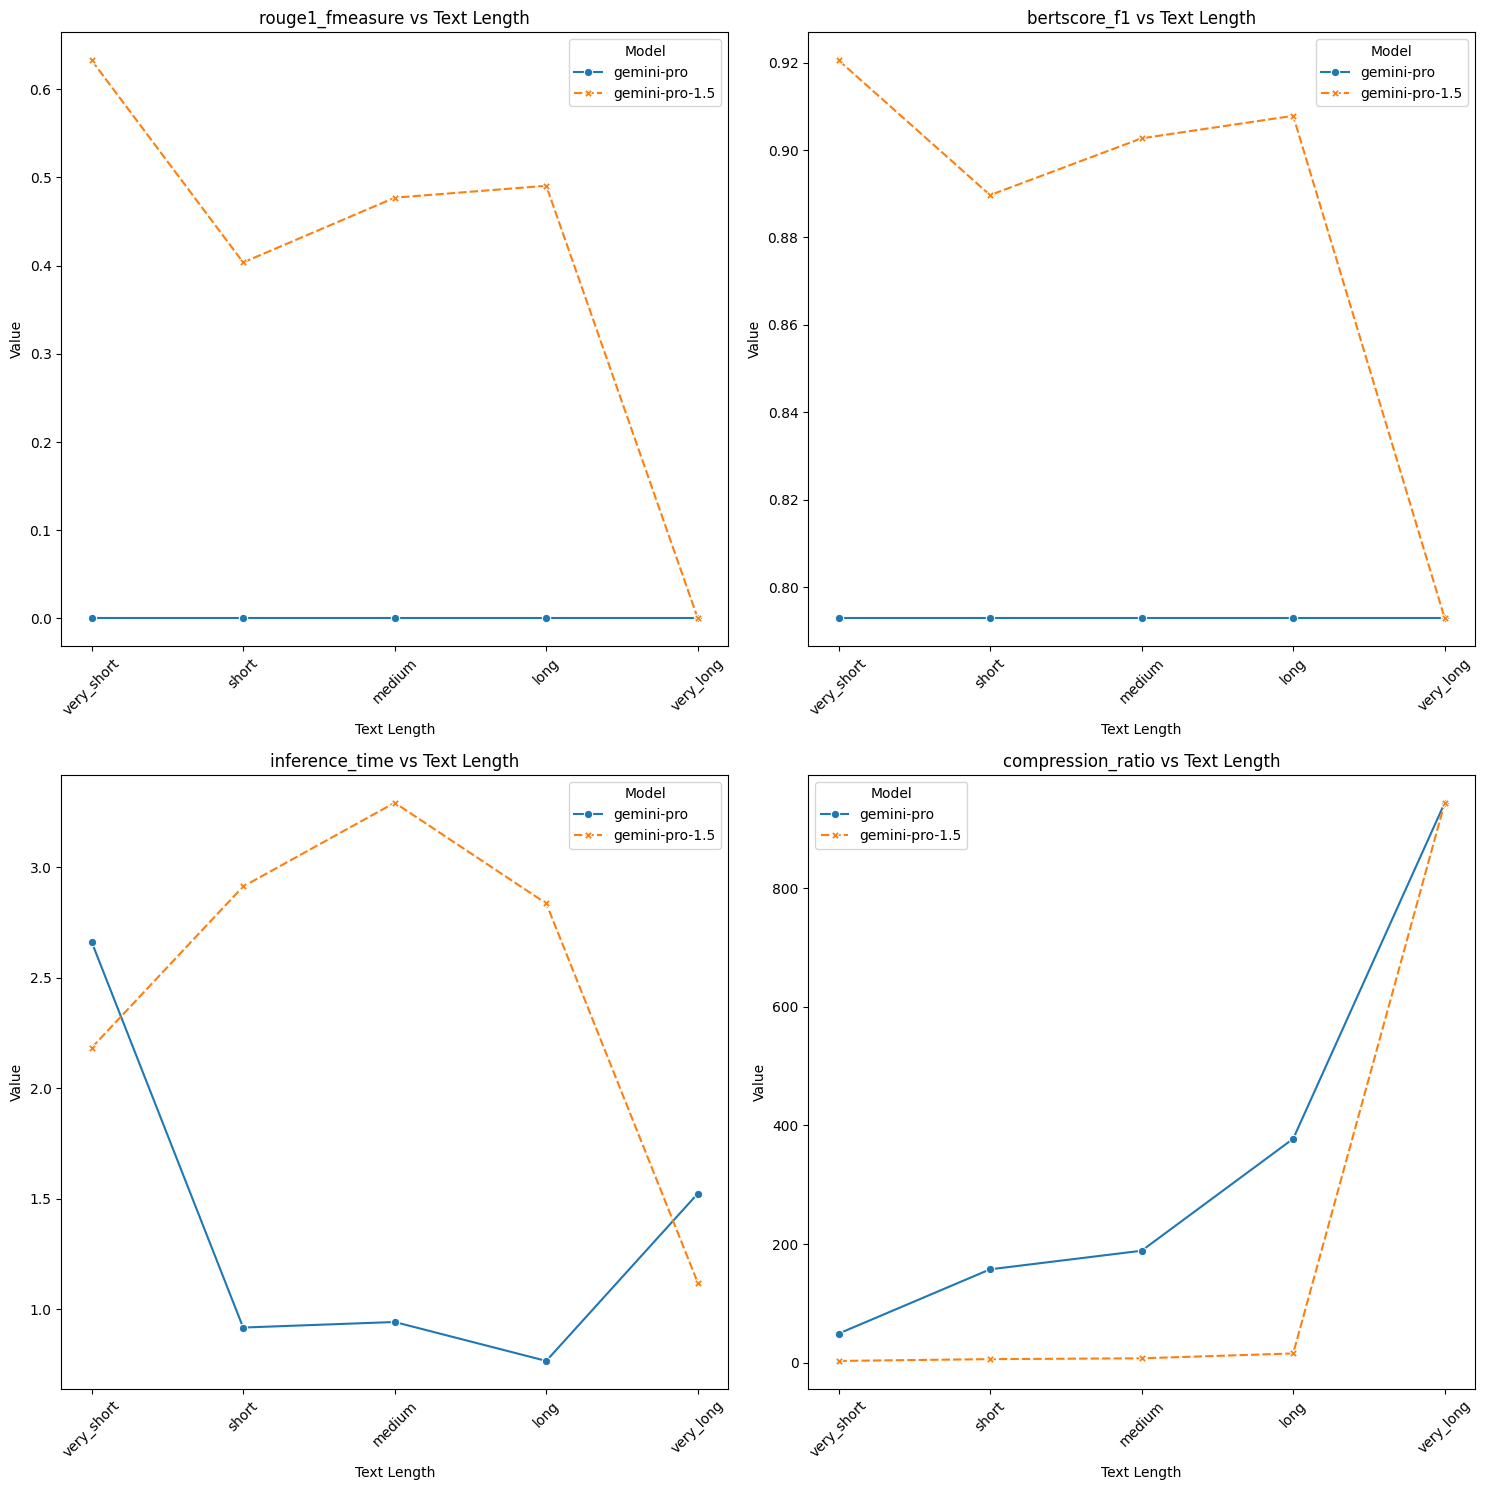


2. Running prompt template comparison...


NameError: name 'test_dataset' is not defined

In [35]:
all_results, report = run_complete_benchmark_project()